In [41]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pymongo
from collections import Counter
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
def create_dataframe(recipes, cutoff=2):
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

def get_label_names(recipes, cat_lvl=2):
    labels = []
    key = 'lvl_{}'.format(cat_lvl)
    for recipe in recipes:
        labels.append(recipe['category'][key])
    return labels

def get_label_numbers(label_names, limit=None):
    ordered_names = [key for key, val in Counter(label_names).most_common()]
    label_nums = [ordered_names.index(label) for label in label_names]
    if not limit:
        return label_nums
    else:
        return [num if num < limit-1 else limit-1 for num in label_nums]
    
def scale_dataframe(df):
    means = np.mean(df, axis=0)
    stds = np.std(df, axis=0)
    return (df - means) / stds, means, stds

In [4]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

In [5]:
cursor = recipes_coll.find()
chili_recipes = []
for recipe in cursor:
    if recipe['category']['lvl_2'] == 'Chili':
        chili_recipes.append(recipe)

In [8]:
df = create_dataframe(chili_recipes, cutoff=5)

In [9]:
df.shape

(223, 80)

In [42]:
X = df.values

In [330]:
X_centered = (df - np.mean(df, axis=0)).values

In [349]:
label_names = get_label_names(chili_recipes, 3)
label_nums = get_label_numbers(label_names, limit=5)
#label_nums

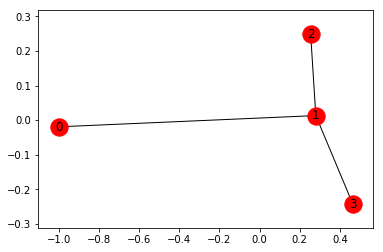

In [146]:
M1 = np.array([[0  ,.01,  0, 0],
               [.01,  0,  1,.5],
               [0  ,  1,  0, 0],
               [0  , .5,  0, 0]])
G_test = nx.Graph(M1)
spr = nx.spring_layout(G_test, scale=1)
nx.draw_networkx(G_test, pos=spr)

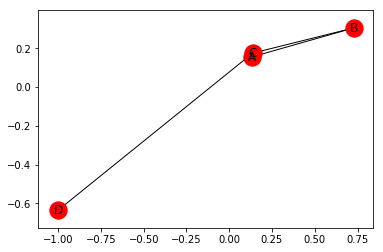

In [179]:
G2 = nx.Graph()
G2.add_edge('A', 'B', weight=0.5)
G2.add_edge('A', 'C', weight=10000)
G2.add_edge('B', 'C', weight=0.1)
G2.add_edge('C', 'D', weight=0.01)
#spr = nx.spring_layout(G2, scale=1, weight='weight')
nx.draw_networkx(G2)

In [307]:
cosine_sims = cosine_similarity(X)
#cosine_sims = cosine_similarity(X_centered)
cosine_sims.shape

(223, 223)

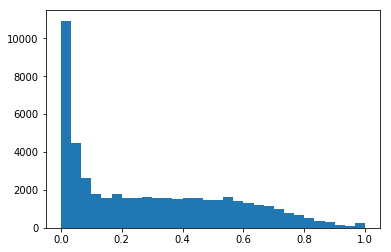

In [309]:
plt.hist(cosine_sims.flatten(), bins=30);

In [331]:
cosine_sims * (cosine_sims > 0.5).astype(int);

In [389]:
G_weighted = nx.Graph()
node_colors = []
for i, num in enumerate(label_nums):
    G_weighted.add_node(i)
    node_colors.append(np.array(['r','y','g','b','k'])[num])
edges_to_show = []
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > 0.7:
            G_weighted.add_edge(i, j, weight=1000*cosine_sims[i,j])
        if cosine_sims[i,j] > 0.7:
            edges_to_show.append((i,j))

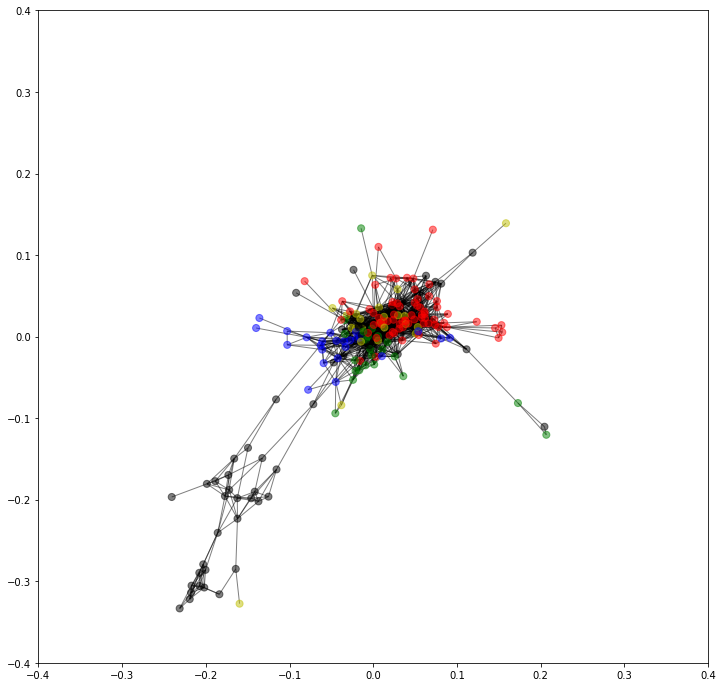

In [392]:
fig, ax = plt.subplots(figsize=(12,12))
spring = nx.spring_layout(G_weighted, k=.4, weight='weight')
nx.draw_networkx(G_weighted,
                 pos=spring,
                 node_size=50,
                 node_color=node_colors,
                 ax=ax,
                 alpha=0.5,
                 with_labels=False,
                 edgelist=edges_to_show)
ax.set_xlim(left=-.4, right=.4)
ax.set_ylim(bottom=-.4, top=.4);

In [384]:
bool_matrix = df.values.astype(bool)

In [328]:
G_jaccard = nx.Graph()
for i, row in enumerate(bool_matrix):
    for j in range(i+1, len(bool_matrix)):
        jac_sim = jaccard_similarity_score(row, bool_matrix[j])
        if jac_sim > 0.9:
            G_jaccard.add_edge(i, j, weight=5*jac_sim)

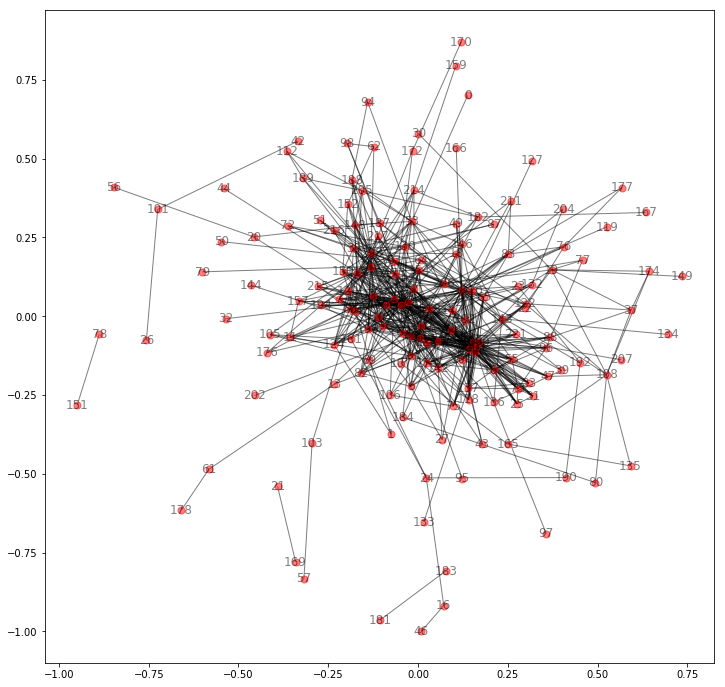

In [329]:
fig, ax = plt.subplots(figsize=(12,12))
spring = nx.spring_layout(G_jaccard, k=.5, weight='weight')
nx.draw_networkx(G_jaccard, pos=spring, node_size=50, ax=ax, alpha=0.5)
#ax.set_xlim(left=-.5, right=.5)
#ax.set_ylim(bottom=-.5, top=.5);

In [346]:
for node in G_weighted.nodes:
    node

0
22
29
35
53
60
68
82
89
93
94
130
134
142
145
146
148
176
186
188
194
203
213
1
2
3
6
7
9
32
103
111
117
124
131
156
161
167
175
178
182
185
195
196
205
208
209
216
48
11
74
99
105
109
150
181
183
215
4
40
69
81
101
157
162
192
5
120
51
106
110
139
218
222
72
138
154
219
8
13
15
21
28
45
50
52
63
65
76
83
87
100
116
121
126
132
137
144
171
173
177
187
197
202
206
210
217
10
54
67
170
172
207
23
24
44
115
143
190
220
12
66
39
49
97
136
164
179
14
169
204
129
16
17
20
46
86
91
98
102
140
160
212
42
18
112
128
189
19
37
41
77
88
96
107
168
174
34
155
25
27
62
125
30
43
85
104
133
33
47
59
73
80
127
135
165
36
122
38
180
114
166
64
57
159
214
158
61
71
79
78
152
75
123
191
108
84
119
92
184
113


{}